Sprintの目的
スクラッチを通してCNNの基礎を理解する

どのように学ぶか
スクラッチで2次元用畳み込みニューラルネットワークを実装した後、学習と検証を行なっていきます。



2.2次元の畳み込みニューラルネットワークスクラッチ

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。


データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。



【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値


$i$ : 配列の行方向のインデックス


$j$ : 配列の列方向のインデックス


$m$ : 出力チャンネルのインデックス


$K$ : 入力チャンネル数


$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ


$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値


$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み


$b_m$ : mチャンネルへの出力のバイアス項


すべてスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$

$\alpha$ : 学習率


$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配


勾配 $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値


$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値


$M$ : 出力チャンネル数


ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [72]:
# データ読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# onehotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# 訓練データと評価データに
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(60000, 28, 28)
(12000, 28, 28)
(60000,)
(12000, 10)


学習に使用するその他クラスの定義
これまでのsprintで定義してきたものを流用します。

In [73]:
class FC:
    """
    Fully connected layers from number of nodes n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in subsequent layers
    initializer : Instances of initialization methods
    optimizer : Instances of optimization methods
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
        
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        # Initialize.
        # Use the initializer method to initialize self.W and self.B
        self.W = self.initializer.W(self.n_nodes1,self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
    def forward(self, X):
        """
        Forward
        Parameters
        ----------
        X : ndarray of the following form, shape (batch_size, n_nodes1)
            Input
        Returns
        ----------
        A : ndarray of the following form, shape (batch_size, n_nodes2)
            Output
        """
        self.X = X
        self.A = np.dot(self.X,self.W) + self.B
        
        return self.activation.forward(self.A)
    
    def backward(self, dZ):
        """
        Backward
        Parameters
        ----------
        dA : ndarray of the following form, shape (batch_size, n_nodes2)
            The gradient flowed in from behind.
        Returns
        ----------
        dZ : ndarray of the following form, shape (batch_size, n_nodes1)
            forward slope
        """
        dA = self.activation.backward(dZ)
        self.dB = np.mean(dA,axis=0)
        self.dW = np.dot(self.X.T,dA)/len(self.X)
        dZ = np.dot(dA,self.W.T)
        
        # Update
        self = self.optimizer.update(self)
        
        return dZ
    
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)
    
class HeInitializer():
    """
    Initialization of weights by He
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return np.random.randn(n_nodes1, n_nodes2)*np.sqrt(2/n_nodes1)
    
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)
    
class SGD:
    """
    stochastic gradient descent method
    Parameters
    ----------
    lr : learning rate
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer : An instance of the layer before the update
        """
        layer.W -= self.lr*layer.dW
        layer.B -= self.lr*layer.dB
        
        return layer
    
class AdaGrad:
    """
    stochastic gradient descent method
    Parameters
    ----------
    lr : learning rate
    """
    def __init__(self, lr):
        self.lr = lr
        self.hW = 0
        self.hB = 0
        
    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer : An instance of the layer before the update
        """
        self.hW += layer.dW*layer.dW
        self.hB = layer.dB*layer.dB
    
        layer.W -= self.lr*layer.dW/(np.sqrt(self.hW) +1e-7)
        layer.B -= self.lr*layer.dB/(np.sqrt(self.hB) +1e-7)
        
        return layer
    
class ReLU():
    """
    Activation function : ReLU function
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        self.A = A
        return np.maximum(self.A,0)
    
    def backward(self,dZ):
        
        return np.where(self.A>0,dZ,0)
    
class Softmax():
    """
    Activation Function : Softmax Function
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        
        return np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)),axis=1,keepdims=True)
    
    def backward(self,dZ):
        return dZ
    
# Mini-batch processing class
class GetMiniBatch:
    """
    Iterator to get the mini-batch

    Parameters
    ----------
    X : ndarray of the following form, shape (n_samples, n_features)
      Training data
    y : ndarray of the following form, shape (n_samples, 1)
      correct value
    batch_size : int
      Batch size
    seed : int
      Seeding random numbers in NumPy
    """
    def __init__(self, X, y, batch_size = 20, seed=None):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1] 
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

畳み込み層の重みとバイアスの初期化クラス

In [74]:
class SimpleInitializerConv2d:
    """重みとバイアスの初期化（畳込み用）"""
    def __init__(self, sigma=0.01):
        """コンストラクタ
        Parameters
        --------------
        sigma : ガウス分布の標準偏差
        """
        self.sigma = sigma
        
    def W(self, F, C, FH, FW):
        """重み初期化
        Parameters
        ----------
        F : フィルタ数
        C : チャンネル数
        FH : フィルターの高さ
        FW : フィルターの横幅
        """
        return self.sigma * np.random.randn(F,C,FH,FW)
    
    def B(self, F):
        """バイアス初期化
        Parameters
        ----------
        F : フィルタ数
        """
        return np.zeros(F)

In [75]:
class SimpleConv2d():
    """2次元畳み込みレイヤ"""
    def __init__(self, F, C, FH, FW, P, S,
                 initializer=None,optimizer=None,activation=None):
        """コンストラクタ
        Parameters
        -------------
        F : フィルタ数
        C : チャンネル数
        FH : フィルターの高さ
        FW : フィルターの横幅
        P : パディング数
        S : ストライド数
        initializer : 初期化
        optimizer : 最適化手法
        activation : 活性化関数
        """
        self.P = P
        self.S = S
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        # 重みとバイアスの初期化
        self.W = self.initializer.W(F,C,FH,FW)
        self.B = self.initializer.B(F)
        
    def output_shape2d(self,H,W,PH,PW,FH,FW,SH,SW):
        """出力サイズ計算
        H : 入力配列の高さ
        W : 入力配列の横幅
        FH : フィルターの高さ
        FW : フィルターの横幅
        PH : パディング数（縦）
        PW : パディング数（横）
        SH : ストライド数（縦）
        SW : ストライド数（横）
        """
        # 高さ計算
        OH = (H +2*PH -FH)/SH +1
        # 横幅計算
        OW = (W +2*PW -FW)/SW +1
        
        return int(OH),int(OW)
    
    def forward(self, X,debug=False):
        """順伝播
        Parameters
        ------------
        X : 入力配列
        """
        # Xをメンバ変数化
        self.X = X
        # 入力配列と重みの大きさ取得
        N,C,H,W = self.X.shape
        F,C,FH,FW = self.W.shape
        # 出力サイズ計算
        OH,OW = self.output_shape2d(H,W,self.P,self.P,FH,FW,self.S,self.S)
        # 各種サイズをメンバ変数化
        self.params = N,C,H,W,F,FH,FW,OH,OW
        # 返り値の初期化（これを上書きしていく）
        A = np.zeros([N,F,OH,OW])
        # 計算のためパディング処理
        self.X_pad = np.pad(self.X,((0,0),(0,0),(self.P,self.P),(self.P,self.P)))

        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 高さでループ（ストライドを考慮）
                for row in range(0,H,self.S):
                    # 横幅でループ（ストライドを考慮）
                    for col in range(0,W,self.S):
                        if self.P == 0 and (W-2 <= col or H-2<=row):
                            continue
                        # 各要素計算
                        A[n,ch,row,col] = \
                        np.sum(self.X_pad[n,:,row:row+FH,col:col+FW]
                               *self.W[ch,:,:,:]) \
                        +self.B[ch]
        # 活性化関数に通して返す
        if debug==True:
            return A
        else:
            return  self.activation.forward(A)
    
    def backward(self, dZ,debug=False):
        """逆伝播
        Parameters
        -----------
        dZ : 逆伝播してきた値
        """
        # 活性化関数の逆伝播処理
        if debug==True:
            dA = dZ
        else:
            dA = self.activation.backward(dZ)
        # 順伝播の際にメンバ変数化しておいた各種サイズを取得
        N,C,H,W,F,FH,FW,OH,OW = self.params
        # 返り値と重みとバイアスの初期化（これを上書きしていく）
        dZ = np.zeros(self.X_pad.shape) # X_padのサイズで初期化していることに注意
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        
        # dZ（逆伝播）
        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 高さでループ（ストライドを考慮）
                for row in range(0,H,self.S):
                    # 横幅でループ（ストライドを考慮）
                    for col in range(0,W,self.S):
                        if self.P == 0 and (W-2 <= col or H-2<=row):
                            continue
                        # 各要素計算
                        dZ[n,:,row:row+FH,col:col+FW] += dA[n,ch,row,col]*self.W[ch,:,:,:]
        
        # X_padのサイズになっているので、不要な部分を削除
        if self.P == 0:
            dZ = np.delete(dZ,[0,H-1],axis=2)
            dZ = np.delete(dZ,[0,W-1],axis=3)
        else:
            dl_rows = range(self.P),range(H+self.P,H+2*self.P,1)
            dl_cols = range(self.P),range(W+self.P,W+2*self.P,1)
            dZ = np.delete(dZ,dl_rows,axis=2)
            dZ = np.delete(dZ,dl_cols,axis=3)
 
        # dW（重み）
        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 高さでループ
                for row in range(OH):
                    # 横幅でループ
                    for col in range(OW):
                        # 各要素計算
                        self.dW[ch,:,:,:] += dA[n,ch,row,col]*self.X_pad[n,:,row:row+FH,col:col+FW]
        
        # dB（バイアス）
        # フィルター数でループ
        for ch in range(F):
            self.dB[ch] = np.sum(dA[:,ch,:,:])
        
        # 重み更新
        self = self.optimizer.update(self)
        
        return dZ

【問題2】小さな配列での2次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。


入力 x、重み w を次のようにします。


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
# CNN2 のフォワードを流す時の入力データ
# (1,1,4,4)
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])
# (2,3,3)
w = np.array([[[ 0.,  0.,  0.],
               [ 0.,  1.,  0.],
               [ 0., -1.,  0.]],
              [[ 0.,  0.,  0.],
               [ 0., -1.,  1.],
               [ 0.,  0.,  0.]]])

フォワードプロパゲーションをすると出力は次のようになります。


1
2
3
4
5
array([[[-4, -4],
        [-4, -4]],
       [[ 1,  1],
        [ 1,  1]]])

次にバックプロパゲーションを考えます。誤差は次のようであったとします。


1
2
3
4
5
6
# (?,1,2,2,)
delta = np.array([[[ -4,  -4],
                   [ 10,  11]],
                  [[  1,  -7],
                   [  1, -11]]])

バックプロパゲーションをすると次のような値になります。パディングがある場合は出力は次のようになります。


1
2
array([[-5,  4],
       [13, 27]])

In [76]:
# CNN2 のフォワードを流す時の入力データ
# (1,1,4,4)
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])
# (2,3,3)
w = np.array([[[ 0.,  0.,  0.],
               [ 0.,  1.,  0.],
               [ 0., -1.,  0.]],
              [[ 0.,  0.,  0.],
               [ 0., -1.,  1.],
               [ 0.,  0.,  0.]]])
b=0

In [77]:
# データの定義
x = np.array([[[[ 1,  2,  3,  4],[ 5,  6,  7,  8],[ 9, 10, 11, 12],[13, 14, 15, 16]]]])
w = np.array([[[[ 0.,  0.,  0.],[ 0.,  1.,  0.],[ 0., -1.,  0.]]],[[[ 0.,  0.,  0.],[ 0., -1.,  1.],[ 0.,  0.,  0.]]]])
da = np.array([[[[ -4,  -4], [ 10,  11]],[[  1,  -7],[  1, -11]]]])

# インスタンス定義と重み上書き
simple_conv_2d = SimpleConv2d(F=2, C=1, FH=3, FW=3, P=0, S=1,initializer=SimpleInitializerConv2d(),optimizer=SGD(),activation=ReLU())
simple_conv_2d.W = w

# 順伝播
A = simple_conv_2d.forward(x,True)
print(A)

# 逆伝播
dZ = simple_conv_2d.backward(da,True)
print(dZ)

[[[[-4. -4.]
   [-4. -4.]]

  [[ 1.  1.]
   [ 1.  1.]]]]
[[[[-5.  4.]
   [13. 27.]]]]


mnistを使ったテスト

In [78]:
# ストライド/パディング/バッチ数の定義
S = 1
P = 0
N = 5 

# 入力配列と重みのサイズ定義
N,C,H,W = (5,1,28,28)
F,C,FH,FW = (4,1,3,3)

# X（入力配列生成）
X_sample = X_train[0:N].reshape(N,C,H,W)

# インスタンス生成
simple_conv_2d = SimpleConv2d(F=4, C=1, FH=3, FW=3, P=1, S=1,initializer=SimpleInitializerConv2d(),optimizer=SGD(),activation=ReLU())

# 順伝播
A = simple_conv_2d.forward(X_sample)
print(A.shape)

# 逆伝播
dA = np.ones(A.shape)
dZ = simple_conv_2d.backward(X_sample)
print(dZ.shape)

(5, 4, 28, 28)
(5, 1, 28, 28)


【問題3】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ


$h$ が高さ方向、 $w$ が幅方向である

問題２で定義済み

In [79]:
simple_conv_2d.output_shape2d(H=6,W=6,PH=0,PW=0,FH=3,FW=3,SH=1,SW=1)

(4, 4)

【問題4】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行（p）と列（q）


$S_{h}, S_{w}$ : 高さ方向（h）と幅方向（w）のストライドのサイズ


$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス


$a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値


$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値


ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。


バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス $(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。



In [80]:
class MaxPool2D():
    """最大プーリング層
    """
    def __init__(self,P):
        """コンストラクタ
        Parameters
        -----------
        P : プーリング幅
        """
        self.P = P
        # 順伝播の返り値
        self.PA = None
        # 最大値のインデックス記録
        self.Pindex = None
        
    def forward(self,A):
        """順伝播
        Parameters
        -----------
        A : 入力配列
        """
        # 入力配列のサイズ
        N,F,OH,OW = A.shape
        # 
        PS = self.P
        # 縦軸と横軸のスライド回数
        PH,PW = int(OH/PS),int(OW/PS)
        
        # 各種パラメータの保存
        self.params = N,F,OH,OW,PS,PH,PW
        
        # プーリング処理のための初期化
        self.PA = np.zeros([N,F,PH,PW])
        self.Pindex = np.zeros([N,F,PH,PW])
        
        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 縦方向スライド回数
                for row in range(PH):
                    # 横方向スライド回数
                    for col in range(PW):
                        # 順伝播の値計算
                        self.PA[n,ch,row,col] = \
                        np.max(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
                        # 最大値のインデックス記録
                        self.Pindex[n,ch,row,col] = \
                        np.argmax(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
                        
        return self.PA
    
    def backward(self,dA):
        """逆伝播の値
        Parameters
        -----------
        dA : 逆伝播してきた値
        """
        # 保存しておいた各種パラメータ取得
        N,F,OH,OW,PS,PH,PW = self.params
        # 逆伝播の値
        dP = np.zeros([N,F,OH,OW])
        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 縦方向スライド回数
                for row in range(PH):
                    # 横方向スライド回数
                    for col in range(PW):
                        # 最大値を取得してきたインデックスの取得
                        idx = self.Pindex[n,ch,row,col]
                        # 逆伝播の一時保存変数
                        tmp = np.zeros((PS*PS))
                        for i in range(PS*PS):
                            # 該当インデックスはその値
                            if i == idx:
                                tmp[i] = dA[n,ch,row,col]
                            # それ以外は0
                            else:
                                tmp[i] = 0
                        # 返り値の該当場所に格納
                        dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
        
        return dP

In [81]:
# テスト
# データ準備
X = np.random.randint(0,9,36).reshape(1,1,6,6)
print("---------------X")
print(X)

# インスタンス生成と順伝播
Pooling = MaxPool2D(P=2)
A = Pooling.forward(X)
print("---------------A")
print(A)

# 逆伝播してきた配列定義
dA = np.random.randint(0,9,9).reshape(A.shape)
print("---------------dA")
print(dA)

# 逆伝播
dZ = Pooling.backward(dA)
print("---------------dZ")
print(dZ)

---------------X
[[[[6 5 2 7 0 3]
   [7 5 1 1 1 7]
   [1 7 6 4 7 2]
   [6 2 6 1 1 8]
   [0 7 8 7 7 6]
   [4 6 1 7 0 5]]]]
---------------A
[[[[7. 7. 7.]
   [7. 6. 8.]
   [7. 8. 7.]]]]
---------------dA
[[[[1 0 5]
   [1 1 3]
   [8 2 1]]]]
---------------dZ
[[[[0. 0. 0. 0. 0. 0.]
   [1. 0. 0. 0. 0. 5.]
   [0. 1. 1. 0. 0. 0.]
   [0. 0. 0. 0. 0. 3.]
   [0. 8. 2. 0. 1. 0.]
   [0. 0. 0. 0. 0. 0.]]]]


【問題5】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。




【問題6】平滑化
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。




In [82]:
class Flatten:
    """平滑化レイヤー"""
    def __ini__(self):
        """コンストラクタ"""
        pass
    def forward(self,X):
        """順伝播
        Parameters
        -----------
        X : 入力配列
        """
        self.shape = X.shape
        return X.reshape(len(X),-1)

    def backward(self,X):
        """逆伝播の値
        Parameters
        -----------
        X : 逆伝播してきた値
        """
        return X.reshape(self.shape)  

In [83]:
# テスト
# データ準備
TEST = np.zeros([20,2,5,5])

# インスタンス生成
flt = Flatten()

# 順伝播
flat_forward = flt.forward(TEST)

# 逆伝播
flat_back = flt.backward(flat_forward)

print('Forward_shape:',flat_forward.shape)
print('Backward_shape:',flat_back.shape)

Forward_shape: (20, 50)
Backward_shape: (20, 2, 5, 5)


3.検証

【問題7】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。




In [84]:
# Scratch CNN
class Scratch2dCNNClassifier():
    """CNNスクラッチ
    """
    def __init__(self, NN, CNN, n_epoch=5, n_batch=1, verbose = False):
        """コンストラクタ
        Parameters
        -----------
        NN : 辞書型でレイヤーのインスタンスを格納
        CNN : 辞書型でレイヤーのインスタンスを格納
        n_epoch : 学習回数
        n_batch : バッチ数
        verbose : ログ出力するか否か
        """
        self.NN = NN
        self.CNN = CNN
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.verbose = verbose
        # ログ記録用
        self.log_loss = np.zeros(self.n_epoch)
        self.log_acc = np.zeros(self.n_epoch)
        
        
    def loss_function(self,y,yt):
        """クロスエントロピー誤差
        Parameters
        ----------
        y : 予測値
        yt : 正解データ
        """
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
    
    def accuracy(self,Z,Y):
        """クロスエントロピー誤差
        Parameters
        ----------
        Z : 予測値
        Y : 正解データ
        """
        return accuracy_score(Y,Z)
                
    def fit(self, X, y, X_val=False, y_val=False):
        """学習
        Parameters
        ----------
        X : 訓練データの説明変数
        y : 訓練データの目的変数
        X_val : 評価データの説明変数
        y_val : 評価データの目的変数
        """
        # 学習回数分ループ
        for epoch in range(self.n_epoch):
            # ミニバッチイテレータ生成
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)
            # バッチの合計損失格納
            self.loss = 0
            # ミニバッチイテレータでループ
            for mini_X_train, mini_y_train in get_mini_batch:              
                ############### 順伝播
                # データ準備
                forward_data = mini_X_train[:,np.newaxis,:,:]
                # 畳込み
                for layer in range(len(self.CNN)):
                    forward_data = self.CNN[layer].forward(forward_data)
                # 平滑化
                flt = Flatten()
                forward_data = flt.forward(forward_data)
                # 通常のNN
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)
                    
                ############### 逆伝播
                # データ準備
                Z = forward_data
                backward_data = (Z - mini_y_train)/self.n_batch
                # 通常のNN
                for layer in range(len(self.NN)-1,-1,-1):
                    backward_data = self.NN[layer].backward(backward_data)
                # 平滑化
                backward_data = flt.backward(backward_data)
                # 畳み込み
                for layer in range(len(self.CNN)-1,-1,-1):
                    backward_data = self.CNN[layer].backward(backward_data)
                
                # 損失計算
                self.loss += self.loss_function(Z,mini_y_train)
            
            if self.verbose:
                print(self.loss/len(get_mini_batch),self.accuracy(self.predict(X),np.argmax(y,axis=1)))
            # 損失記録用
            self.log_loss[epoch] = self.loss/len(get_mini_batch)
            self.log_acc[epoch] = self.accuracy(self.predict(X),np.argmax(y,axis=1))
            
    def predict(self, X):
        """予測
        Parameters
        ----------
        X : 説明変数
        """
        # データ準備
        pred_data = X[:,np.newaxis,:,:]
        
        # 畳込み
        for layer in range(len(self.CNN)):
            pred_data = self.CNN[layer].forward(pred_data)
        # 平滑化
        pred_data = flt.forward(pred_data)
        # 通常のNN
        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)
        # 最も大きい値のインデックスを採用
        return np.argmax(pred_data,axis=1)

In [85]:
# レイヤー群定義
NN = {
    0:FC(6760, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
    1:FC(400, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
    2:FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
}

CNN = {
    0:SimpleConv2d(
        F=10, C=1, FH=3, FW=3, P=0, S=1,
        initializer=SimpleInitializerConv2d(),
        optimizer=SGD(),
        activation=ReLU())
}

In [86]:
# CNNクラスのインスタンス化
cnn1 = Scratch2dCNNClassifier(NN=NN,CNN=CNN,n_epoch=10,n_batch=200,verbose=True)

In [87]:
# 学習
cnn1.fit(X_train[0:1000],y_train_one_hot[0:1000])

0.2861235500373215 0.117
0.23013543316121096 0.116
0.23020646790769642 0.117
0.23011176937152503 0.117
0.23007344829537155 0.117
0.23008565095346523 0.117
0.22999914686300346 0.117
0.22998645878228915 0.116
0.23004294623810545 0.117
0.22996644116195925 0.117


In [88]:
# 予測
y_pred = cnn1.predict(X_val[0:100])

# ACC算出
accuracy = accuracy_score(np.argmax(y_val[0:100],axis=1), y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.140


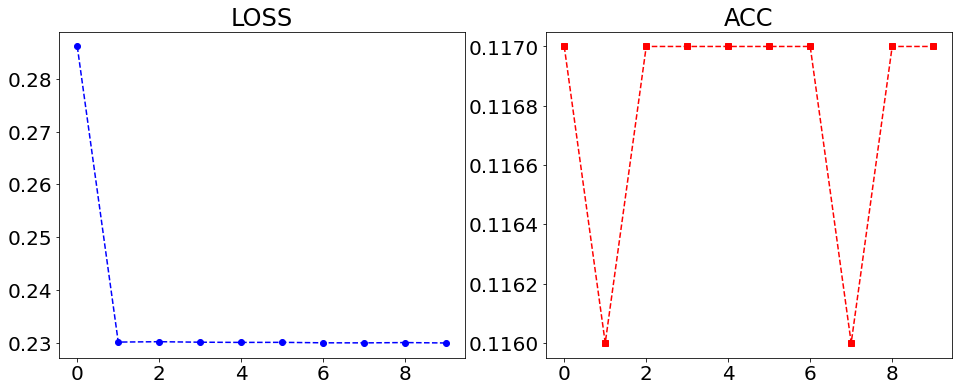

In [89]:
# 学習曲線の可視化
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(cnn1.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(cnn1.log_acc,'rs--');

【問題8】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。


Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.


https://diveintocode.gyazo.com/83358987a273743a589b9388dfdf59ac


※上記論文から引用


サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。


畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
ReLU
最大プーリング
畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
ReLU
最大プーリング
平滑化
全結合層　出力ノード数120
ReLU
全結合層　出力ノード数84
ReLU
全結合層　出力ノード数10
ソフトマックス関数



In [90]:
#略

【問題9】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。


どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。


《参考》


Applications - Keras Documentation




In [91]:
#略

【問題10】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。


1.


入力サイズ : 144×144, 3チャンネル
フィルタサイズ : 3×3, 6チャンネル
ストライド : 1
パディング : なし

2.


入力サイズ : 60×60, 24チャンネル
フィルタサイズ : 3×3, 48チャンネル
ストライド　: 1
パディング : なし

3.


入力サイズ : 20×20, 10チャンネル
フィルタサイズ: 3×3, 20チャンネル
ストライド : 2
パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。




1.

* 入力サイズ : 144×144, 3チャンネル
* フィルタサイズ : 3×3, 6チャンネル
* ストライド : 1
* パディング : なし

→ 出力サイズ：6×142×142

→ パラメータ数（重み）（F×C×FH×FW）：162

→ パラメータ数（バイアス）（F）：6

2.

* 入力サイズ : 60×60, 24チャンネル
* フィルタサイズ : 3×3, 48チャンネル
* ストライド　: 1
* パディング : なし

→ 出力サイズ：48×58×58

→ パラメータ数（重み）（F×C×FH×FW）：10368

→ パラメータ数（バイアス）（F）：48

3.

* 入力サイズ : 20×20, 10チャンネル
* フィルタサイズ: 3×3, 20チャンネル
* ストライド : 2
* パディング : なし

→ 出力サイズ：20x9x9

→ パラメータ数（重み）（F×C×FH×FW）：1800

→ パラメータ数（バイアス）（F）：20

【問題11】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。


7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
高さや幅方向を持たない1×1のフィルタの効果